# Предсказание коэффициента восстановления золота

# Задача

Есть данные с параметрами химического состава сырья на разных этапах очистки золотой руды. Нужно **обучить модель для предсказания коэффициента восстановления золота из золотосодержащей руды**. Качество модели опрделеяется метрикой **Итоговый sMAPE**, рассчитывающейся по формуле:

$$
sMAPE_{итоговый} = 25\% \times sMAPE_{rougher} + 75\% \times sMAPE_{final} 
$$

где индексы rougher и final означают этапы обработки руды, для которых расчитывается **sMAPE**.

Показатель **sMAPE** для обоих этапов - rougher и final - рассчитывается по формуле:

$$
sMAPE = {{{1}\over {N}} \sum_{i=1}^N {|{y - \hat y|}\over{(|y| + |\hat y|) / 2}} \times 100\% }
$$

где:  
$ y $ — целевой признак;  
$ \hat y $ — предсказание целевого признака;  
$ N $ — количество объектов.  

Золотая руда проходит этап флотации, первый этап очистки и второй этап очистки, на каждом из которых образуются концентрат, который идет на следующий этап, и отвальные хвосты (tails). Для каждого из этапов есть несколько типов параметров (input - параметры поступающего на этап сырья, output - параметры выхода этапа, state - параметры текущего состояния сырья, и calculation - расчетные характеристики), и для каждого типа параметров есть параметры, включающие в себя показатели концентрации металлов в сырье, концентрацию реагентов, физико-химические характеристики вроде объема воздуха, уровня жидкости и размера гранул и т.д. 

Целевым признаком в нашем случае для обоих этапов rougher (флотация) и (final) является показатель **Recovery** - показатель эффективности обогащения.

$$
Recovery = {{C \times (F - T)}\over{F \times (C - T)}} \times 100\% 
$$

где:  
$ C $ — доля золота в концентрате после флотации/очистки;  
$ F $  — доля золота в сырье/концентрате до флотации/очистки;;  
$ T $ — доля золота в отвальных хвостах после флотации/очистки.  

# 1. Подготовка данных

## Предварительное изучение данных

Загрузим необходимые нам библиотеки и методы и обновим библиотеку scikit learn, чтобы пользоваться методом KNNImputer, с помощью которого заполним пропуски.

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyRegressor

from sklearn.utils import shuffle
import numpy as np
from scipy import stats as st
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

import math

In [2]:
from sklearn.impute import KNNImputer

In [3]:
random = 12345

Загрузим данные.

In [4]:
df_train = pd.read_csv('...') 


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [6]:
df_train.shape

(16860, 87)

В датасете с обучающими данными есть пропуски. Обратим внимание на количество столбцов - их 87.  

In [7]:
df_test = pd.read_csv('...') 


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [9]:
df_test.shape

(5856, 53)

В тестовом датасете также есть пропуски, кроме того в нем всего 53 столбца. Часть признаков - 34 столбца - из обучающего датасета отсутствует. Выведем их.

In [10]:
train_columns = pd.DataFrame(data = df_train.columns, columns = ['columns'])
test_columns =  list(df_test.columns)
def missing_columns(i):
    if (i in test_columns)==True:
        return 0
    else:
        return 1

train_columns['is_missed_in_test'] = train_columns['columns'].apply(missing_columns)
missing_columns = train_columns.query('is_missed_in_test == 1')
missing_columns['columns']

1                           final.output.concentrate_ag
2                           final.output.concentrate_pb
3                          final.output.concentrate_sol
4                           final.output.concentrate_au
5                                 final.output.recovery
6                                  final.output.tail_ag
7                                  final.output.tail_pb
8                                 final.output.tail_sol
9                                  final.output.tail_au
14                primary_cleaner.output.concentrate_ag
15                primary_cleaner.output.concentrate_pb
16               primary_cleaner.output.concentrate_sol
17                primary_cleaner.output.concentrate_au
18                       primary_cleaner.output.tail_ag
19                       primary_cleaner.output.tail_pb
20                      primary_cleaner.output.tail_sol
21                       primary_cleaner.output.tail_au
30        rougher.calculation.sulfate_to_au_conc

In [11]:
len(missing_columns['columns'])

34

Загрузим исходные данные. 

In [12]:
df = pd.read_csv('...')


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [14]:
df.shape

(22716, 87)

In [15]:
len(df_train) + len(df_test) - len(df)

0

Как и можно было предположить, в исходном датасете количество объектов равно сумме объектов в обучающем и тестовом датасетах, а количество признаков в нем такое же, что и в обучающем.

Обратим внимание, что по условию объекты индексируются по дате и времени. Это значит, что дата и время уникальны для каждого объекта, по ним можно идентифицировать строки. Проверим это.

In [16]:
len(df['date'].unique()) - len(df)

0

Действительно, каждое сочетание даты и времени уникально.

Типы данных практически у всех столбцов - float, что отвечает сути признаков. Исключение - столбец date в каждом наборе данных. Его нужно будет заменить на соответствующий природе признака тип datetime.

### Вывод

Во всех наборах данных присутствуют пропуски. Во всех наборах данных в столбце date указан неподходящий тип данных object.  
В исходных данных и в обучающем наборе 87 признак, в тестовом - 53. Более подробное рассмотрение 34 не вошедших в тестовый набор призаков будет произведен ниже. 

## Проверка расчета эффективности обогащения

Проверим, правильно ли расчитана эффективность обогащения для признака rougher.output.recovery. Напишем функцию, которая принимает датафрейм и расчитывает rougher.output.recovery по переданной заказчиком формуле. Передадим функции обучающий датасет с объектами с не отсутствующими значениями рассчитанного заказчиком признака rougher.output.recovery, чтобы сравнение было релевантным. 

In [17]:
def recovery_check(data):
    c = data['rougher.output.concentrate_au']
    f = data['rougher.input.feed_au']
    t = data['rougher.output.tail_au']
    try:
        recovery = ((c * (f-t)) / (f * (c - t))) * 100
        return recovery
    except:
        return np.nan

recovery_check_results = recovery_check(df_train[df_train['rougher.output.recovery'].isna()==False])


Проверим, насколько рассчитанные нами показатели отличаются от расчетов заказчика, рассчитав среднее абсолютное отклонение между ними.  

In [18]:
mae = mean_absolute_error(df_train[df_train['rougher.output.recovery'].isna()==False]['rougher.output.recovery'], recovery_check_results)
mae

9.444891926100695e-15

### Вывод

Среднее абсолютное отклонение между нашими расчетами и расчетами заказчика не значительно, таким образом, рассчитанному заказчиком показателю recovery можно верить. 

## Не вошедшие в тестовую выборку признаки

Рассмотрим поподробнее признаки, не вошедшие в тестовую выборку. Вызовем их еще раз.

In [19]:
missing_columns

,columns,is_missed_in_test
1,final.output.concentrate_ag,1
2,final.output.concentrate_pb,1
3,final.output.concentrate_sol,1
4,final.output.concentrate_au,1
5,final.output.recovery,1
6,final.output.tail_ag,1
7,final.output.tail_pb,1
8,final.output.tail_sol,1
9,final.output.tail_au,1
14,primary_cleaner.output.concentrate_ag,1


In [20]:
print(list(missing_columns.loc[[31,32],'columns']))

['rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.floatbank11_sulfate_to_au_feed']


Обратим внимание на то, что большинство признаков, не вошедших в тестовую выборку, относятся к типу параметров output. Данный тип параметров описывает продукт этапа обработки руды, фактически, результат обработки на этом этапе. К результатам обработки помимо количественно измеримого выхода металлов в концентрате и хвостах в БД заказчика еще относится рассчитываемый показатель эффективности обогащения золота из руды, т.е. показатель recovery.  
Для нас важно как раз то, что величины, которые нам нужно спрогнозировать - ougher.output.recovery и final.output.recovery - относятся именно к этому типу параметров, и оба отсутствуют в тестовой выборке.  
Обратим также внимание на то, что в тестовой выборке отсутсвуют помимо output расчетные параметры типа calculation, хоть и в небольшом количестве.

## Обработка данных

### Замена типов данных

Заменим тип данных в столбцах date во всех выборках.

In [21]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')

### Удаление пропусков

Используем KNNImputer для того, чтобы заполнить пропуски в данных. KNNImputer заменит пропуск  значение по  ближайшим к нему объектам, значения которых уже известны.  
Из определения метода следует, что с увеличением выборки точность заполнения увеличится, потому что в части выборки могут отсутствовать более близкие к объекту "соседи", которые есть в полном наборе данных. Поэтому нам стоит заполнить таблицу с исходным датасетом.  
Обработка исходного датасета также будет полезна, поскольку, как мы выяснили в предыдущем пункте, целевой признак в тестовой выборке отсутствует, его нам нужно вычленять из исходных данных.
Однако по условию кейса данные уже поделены на тестовую и обучающую выборки, поэтому чтобы соответствовать условиям добавим в исходные данные столбец, значения в котором будут принимать единицу, если объект присутствует в обучающей выборке, и ноль, если в тестовой. 

In [22]:
%%time

train_date = list(df_train['date'])

def in_train(date):
    if (date in train_date) == True:
        return 1
    else:
        return 0

df['in_train'] = df['date'].apply(in_train)



Wall time: 7.91 s


In [23]:
len(df.query('in_train == 1'))

16860

In [24]:
len(df.query('in_train == 0'))

5856

In [25]:
len(df.query('in_train == 0')) + len(df.query('in_train == 1'))

22716

Количество объектов со значением 1 в столбце-маркере равно количеству объектов в тренировочной выборке, аналогично количество объектов со значением 0 в этом столбце совпадает количеством объектов в тестовой выборке.  
Дополнительно проверим себя, сопоставив даты - идентифицирующие значения объектов - из выборок и даты объектов с соответствующей пометкой из общего датасета. Определим функцию, принимающую столбцы date из выборок и из общего датасета и возвращающую таблицу с информацией о несовпадениях этих дат. Сперва сравним даты обучающих объектов.

In [26]:
def date_check(full, sample):
    dict_date_check = {'full': list(full), 'train': list(sample) }
    df_date_check = pd.DataFrame(data = dict_date_check)
    df_date_check['errors'] = (df_date_check['full'] != df_date_check['train'])
    return df_date_check

full_train_date_check = date_check(df.query('in_train == 1')['date'], df_train['date'])


Выведем даты, которые не совпали. 

In [27]:
full_train_date_check.query('errors == True')

,full,train,errors


Таких нет.  
Проделаем то же самое с тестовой выборкой.

In [28]:
full_test_date_check = date_check(df.query('in_train == 0')['date'], df_test['date'])
full_test_date_check.query('errors == True')

,full,train,errors


Даты совпали везде, можем с чистой совестью использовать один общий датафрейм, чем значительно упростим себе работу и увеличим качество заполнения пропусков.  

Применим KNNImputer к общему датасету. Передадим ему общий датасет кроме двух целевых признаков, дат и нашего нового столбца-маркера.   

Поскольку заполнять пропуски в целевом столбце некорректно, предварительно удалим объекты с пропусками в целевом признаке.

In [29]:
df[['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    3119
final.output.recovery      1963
dtype: int64

Пропусков, даже если строки полностью совпадают, очень много, но с ними ничего не сделаешь: пропуски в целевом признаке мы заполнить не можем.

In [30]:
df.dropna(subset = ['rougher.output.recovery', 'final.output.recovery'], inplace = True)
len(df)

19439

In [31]:
%%time

imputer = KNNImputer()
df_dropped = df.drop(['date','in_train'], axis = 1)
imputer.fit(df_dropped)
imputer_data = imputer.transform(df_dropped)
df2 = pd.DataFrame(data = imputer_data, columns = df.columns.drop(['date','in_train']))


Wall time: 6.08 s


In [32]:
df.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,in_train
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,1
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,1
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,1
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,1
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,1
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915,1
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470,1
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070,1
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188,1
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855,1


In [34]:
df2['date'] = df['date'] 
df2['in_train'] = df['in_train']

df2_neworder = list(df.columns)
df2 = df2.reindex(columns = df2_neworder)
df2.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,in_train
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,1.0
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,1.0
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,1.0
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,1.0
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,1.0
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915,1.0
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470,1.0
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070,1.0
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188,1.0
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855,1.0


In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 88 columns):
date                                                  16632 non-null datetime64[ns]
final.output.concentrate_ag                           19439 non-null float64
final.output.concentrate_pb                           19439 non-null float64
final.output.concentrate_sol                          19439 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19439 non-null float64
final.output.tail_pb                                  19439 non-null float64
final.output.tail_sol                                 19439 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19439 non-null float64
primary_cleaner.input.depressant     

Пропуски заполнены во всем датасете с общими данными, кроме целевых столбцов. Мы не заполнили эти столбцы методом K ближайших соседей, потому что это фактически означало бы предсказание целевого признака, что мы хотим сделать с помощью моделей.

In [36]:
df2['rougher.output.recovery'].isna().sum() / len(df2)

0.0

In [37]:
df2['final.output.recovery'].isna().sum() / len(df2)

0.0

In [38]:
df2['rougher.output.recovery'].isna().sum() + df2['final.output.recovery'].isna().sum()

0

### Поиск дубликатов

Поищем дубликаты.

In [39]:
df.drop('in_train', axis = 1).duplicated().sum()

0

Дубликаты не обнаружены.

# 2. Анализ данных

## Изменение концентрации металлов в зависимости от этапа

In [44]:
metals_pivot = pd.DataFrame()
phases = ['rougher.input.feed', 'rougher.output','primary_cleaner.output', 'final.output']
au = ['rougher.input.feed_au',
             'rougher.output.concentrate_au',
             'primary_cleaner.output.concentrate_au',
             'final.output.concentrate_au']
ag = ['rougher.input.feed_ag',
             'rougher.output.concentrate_ag',
             'primary_cleaner.output.concentrate_ag',
             'final.output.concentrate_ag']
pb = ['rougher.input.feed_pb',
             'rougher.output.concentrate_pb',
             'primary_cleaner.output.concentrate_pb',
             'final.output.concentrate_pb']

metals = [au, ag, pb]

for m in metals:
    mean_list = []
    median_list = []
    for i in m:
        mean_list.append(df2[i].mean())
        median_list.append(df2[i].median())
    metals_pivot['%s_mean' % m] = mean_list
    metals_pivot['%s_median' % m] = median_list
metals_pivot.index = phases
metals_columns = ['au_mean','au_median', 'ag_mean','ag_median', 'pb_mean','pb_median' ]
metals_pivot.columns = metals_columns
metals_pivot

,au_mean,au_median,ag_mean,ag_median,pb_mean,pb_median
rougher.input.feed,8.266097,8.125839,8.794927,8.593574,3.595075,3.530821
rougher.output,19.772000,20.280214,11.994759,12.098115,7.606272,7.742580
primary_cleaner.output,32.119400,32.841295,8.442408,8.507298,9.819528,10.141211
final.output,44.076513,45.011244,5.168419,5.066039,9.978909,10.102602


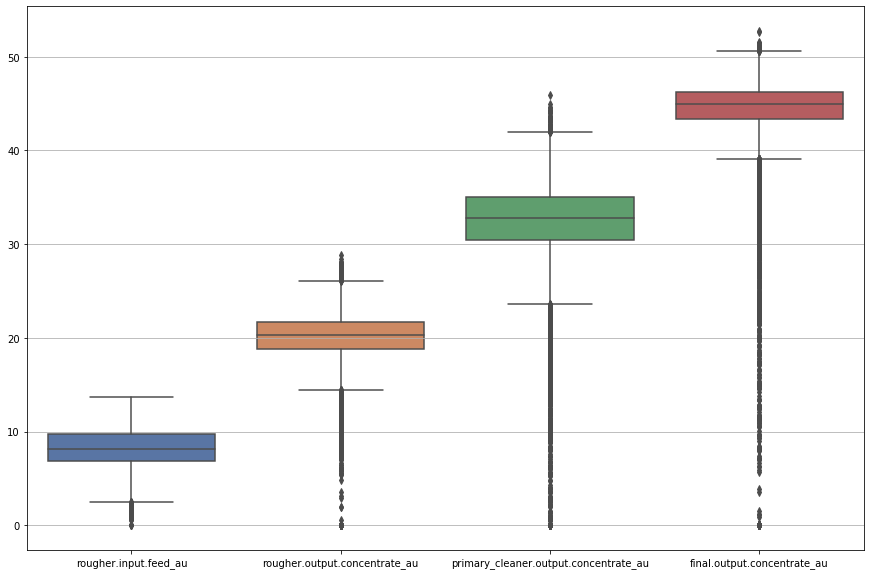

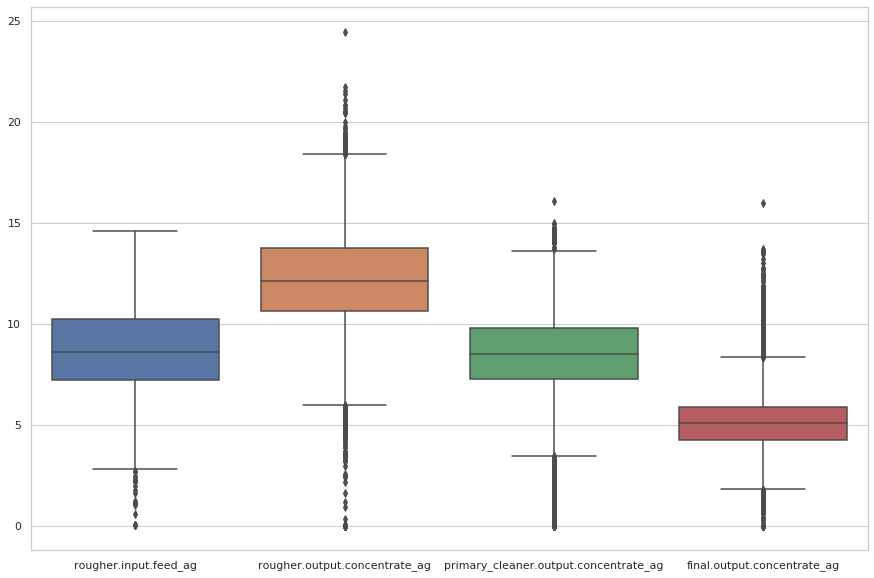

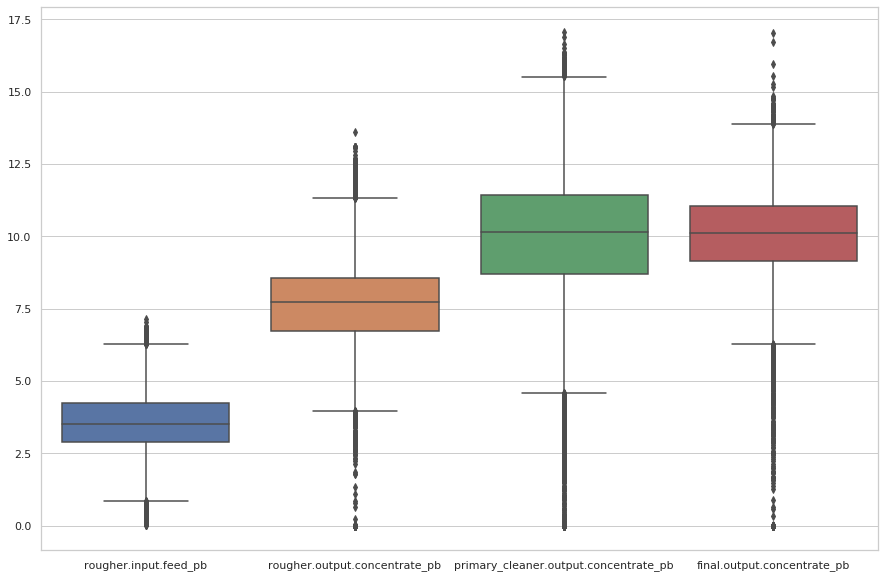

In [45]:
for m in metals:
    fig = plt.figure()
    fig.set_size_inches(15,10)
    ax1 = fig.add_subplot()
    ax1.grid(True)
    sns.set(style = 'whitegrid')
    sns.boxplot(data = df2[m])

На диаграммах размаха хорошо видно, что золото увеличивает свою концентрацию с каждым этапом обработки, начиная с флотации, притом увеличивается концентрация золота стабильно на очень близкие величины, примерно на 12-12.5 п.п. от этапа к этапу. Также стоит отметить весьма небольшой межквартильный размах по этому металлу, что говорит о довольно близком к медиане распределении значений, притом на каждом этапе.  
У серебра концентрация до флотации сопоставима с золотом, как и у золота, концентрация увеличивается после флотации, но после первичной и вторичной обработки его концентрация каждый раз падает. Межквартильный размах увеличивается.
Сразвинтельно большой межквартильный размах и у свинца, хотя в отличие от серебра его концентрация не сокращается. Тем не менее, его увеличение не так стабильно, как у золота, и после второго этапа отчистки его концентрация не растет.  
У на самом первом этапе (до флотации) среднее значение концентрации больше медианы, после в большинстве случаев медиана больше среднего. Это значит, что слишком больших значений, из-за которых чувствительное к выбросам среднее может быть велико относительно медианы, нет. Однако стоит дополнительно проверить нулевые значения, их относительно большое количество могло увеличить медиану. 

### Вывод

Стабильное увеличение концентрации от этапа к этапу наблюдается у золота, у свинца концентрация перестает расти после второго этапа очистки, у серебра - падает после первого. Также у металлов, кроме золота, достаточно сравнительно большой межквартильный размах.  
В целом, выводы довольно закономерны для целенаправленной преработки золотой руды. Цель - увеличить концентрацию золота, остальные металлы не так важны.  

## Распределение гранул сырья

Сравним распределения размеров гранул сырья в тестовой и обучающей выборках.  

Настало время поделить общий датасет с помощью столбца-маркера, который мы добавили.

In [46]:
df2_train = df2.query('in_train == 1')
df2_test = df2.query('in_train == 0')

Посмотрим на распределения размеров гранул в выборках.

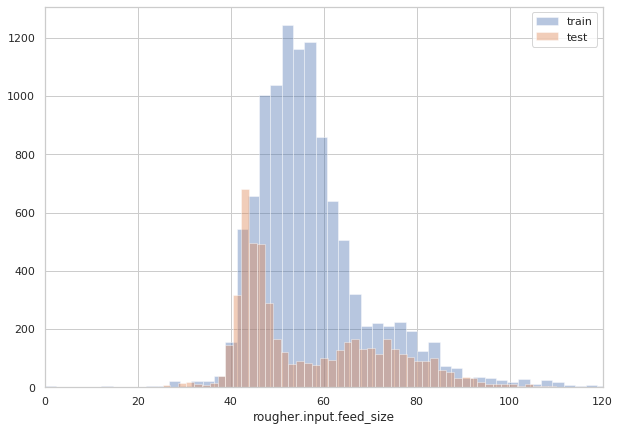

In [47]:
fig = plt.figure()
fig.set_size_inches(10,7)
ax1 = fig.add_subplot()
ax1.grid(True)
sns.distplot(df2_train['rougher.input.feed_size'], bins = 200, label = 'train', kde = False)
sns.distplot(df2_test['rougher.input.feed_size'], bins = 200, label = 'test', kde = False)
plt.xlim(0, 120)
plt.legend()
plt.show()

На графике видно, что распределения размеров гранул сырья тестовой и обучающей выборок похожи, оба распределения обладают скошенностью влево. Если мы добавим график плотности распределения, мы убедимся, что у тестовой выборки распределение скошено все-таки сильнее, что не удивительно: на меньших выборках вероятность диспропорций и отличий от нормального выше. 

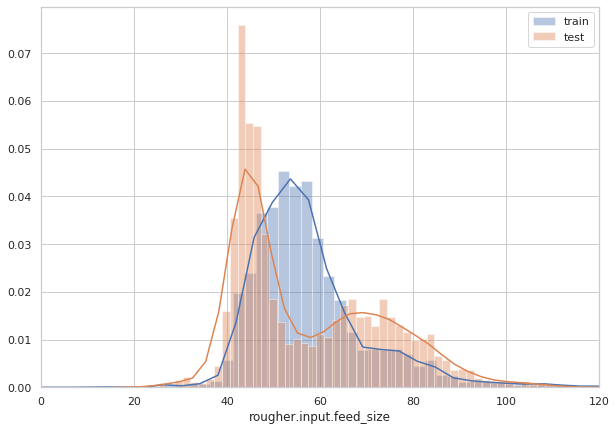

In [48]:
fig = plt.figure()
fig.set_size_inches(10,7)
ax1 = fig.add_subplot()
ax1.grid(True)
sns.distplot(df2_train['rougher.input.feed_size'], bins = 200, label = 'train', kde = True)
sns.distplot(df2_test['rougher.input.feed_size'], bins = 200, label = 'test', kde = True)
plt.xlim(0, 120)
plt.legend()
plt.show()

### Вывод

В целом, распределения достаточно похожи. 

## Суммарная концентрация веществ

In [49]:
df2['rougher.input.feed_sum'] = (df2['rougher.input.feed_au'] 
                                 + df2['rougher.input.feed_ag'] 
                                 + df2['rougher.input.feed_pb'] 
                                 + df2['rougher.input.feed_sol'])
df2['rougher.output.concentrate_sum'] = (df2['rougher.output.concentrate_au'] 
                                 + df2['rougher.output.concentrate_ag'] 
                                 + df2['rougher.output.concentrate_pb'] 
                                 + df2['rougher.output.concentrate_sol'])
df2['rougher.output.tail_sum'] = (df2['rougher.output.tail_au'] 
                                 + df2['rougher.output.tail_ag'] 
                                 + df2['rougher.output.tail_pb'] 
                                 + df2['rougher.output.tail_sol'])
df2['primary_cleaner.output.concentrate_sum'] = (df2['primary_cleaner.output.concentrate_au'] 
                                 + df2['primary_cleaner.output.concentrate_ag'] 
                                 + df2['primary_cleaner.output.concentrate_pb'] 
                                 + df2['primary_cleaner.output.concentrate_sol'])
df2['primary_cleaner.output.tail_sum'] = (df2['primary_cleaner.output.tail_au'] 
                                 + df2['primary_cleaner.output.tail_ag'] 
                                 + df2['primary_cleaner.output.tail_pb'] 
                                 + df2['primary_cleaner.output.tail_sol'])
df2['final.output.concentrate_sum'] = (df2['final.output.concentrate_au'] 
                                 + df2['final.output.concentrate_ag'] 
                                 + df2['final.output.concentrate_pb'] 
                                 + df2['final.output.concentrate_sol'])
df2['final.output.tail_sum'] = (df2['final.output.tail_au'] 
                                 + df2['final.output.tail_ag'] 
                                 + df2['final.output.tail_pb'] 
                                 + df2['final.output.tail_sol'])


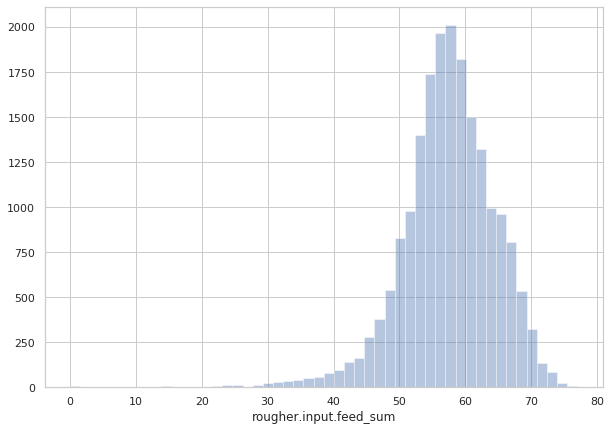

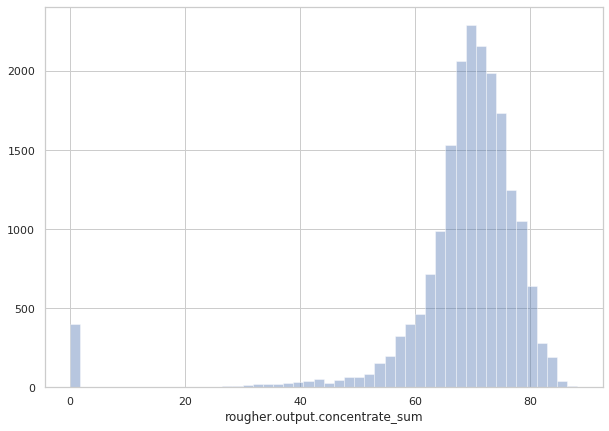

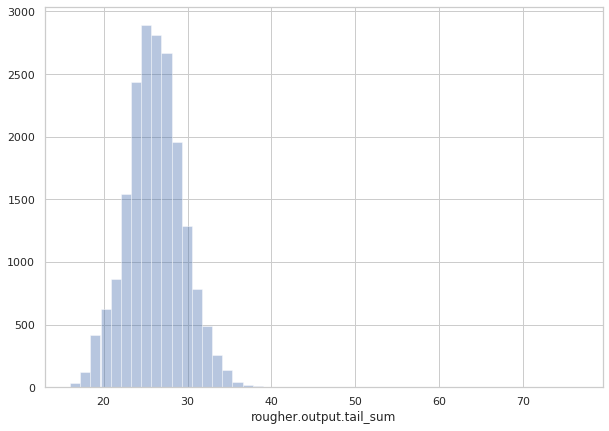

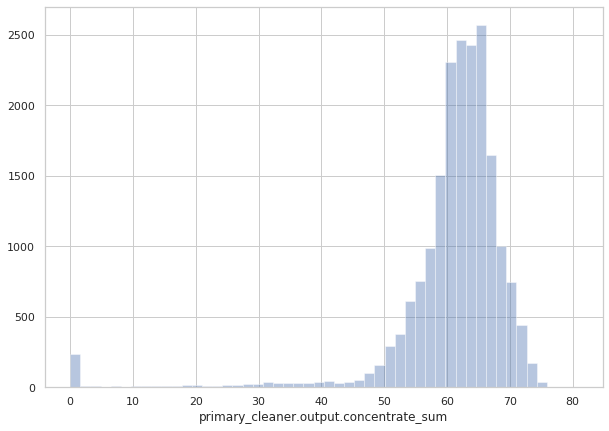

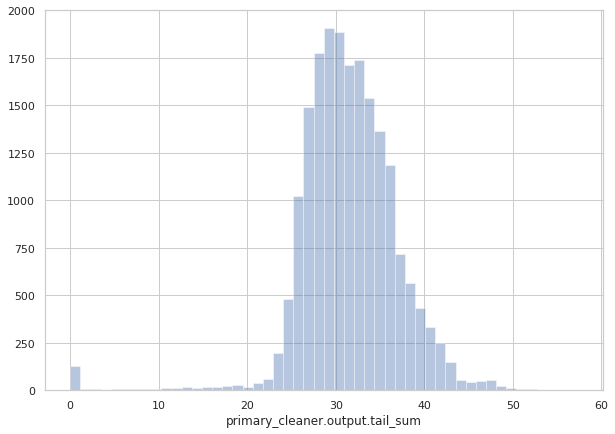

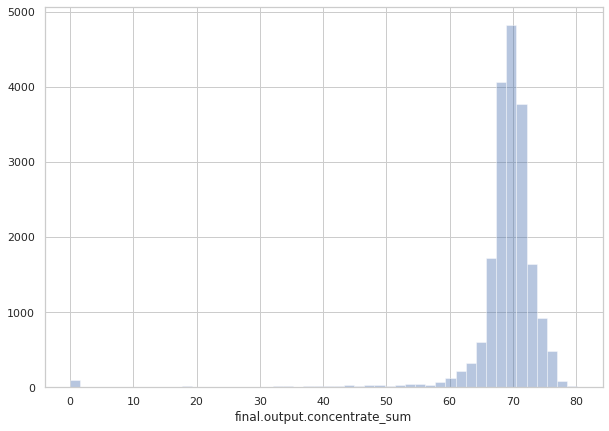

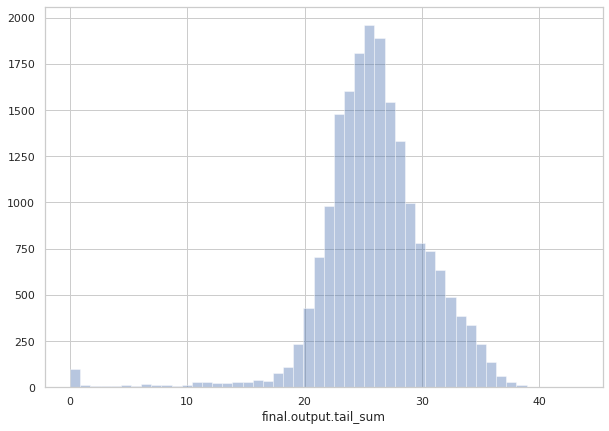

In [50]:
sum_conc_list = [df2['rougher.input.feed_sum'],
                 df2['rougher.output.concentrate_sum'], 
                 df2['rougher.output.tail_sum'],
                 df2['primary_cleaner.output.concentrate_sum'], 
                 df2['primary_cleaner.output.tail_sum'],
                 df2['final.output.concentrate_sum'],
                 df2['final.output.tail_sum'] ]
for i in sum_conc_list:
    fig = plt.figure()
    fig.set_size_inches(10,7)
    ax1 = fig.add_subplot()
    ax1.grid(True)
    sns.distplot(i, bins = 50, kde = False)
    plt.show()

На графиках можно наблюдать некоторое количество нулевых значений суммарной концентрации веществ.  
Они не выглядят аномалиями на первый взгляд и, теоретически, такое распределение возможно, ведь потенциально могут существовать некачественное сырье, в котором концентрация ценных металлов и веществ нулевое.  
Однако вызывает подозрение тот факт, что, во-первых, сырья, в котором концентрация нужных веществ мала или близка к нулю, мало, хоть оно и присутствует, и оно уменьшается с уменьшением концентрации веществ, то количество сырья с нулевой концентрацией выпадает из этого тренда, резко увеличиваясь.
Во-вторых, смущает то, что такого сырья больше именно на черновом и финальном концентрате, который идет на дальнейшую обработку, и меньше в хвостах, хотя по идее должно быть наоборот.  
В-третьих, обращаем внимание, что речь идет о нулевой концентрации всех веществ. Даже если предположить, что в производство попало некачественное сырье, в котором вообще нет золота, вероятность того, что в нем не будет и других наблюдаемых веществ, мала. Такое количество полностью пустой золотоносной руды ставит под сомнение либо ее фактическое существование, либо качаество отбора сырья для производства.
Из этого делаем вывод, что, скорее всего, имеет место аномалия или просто ошибка, поэтому удалим из обеих выборок объекты с концентрацией всех веществ меньше десяти - меньше этого значения концентрации металлов даже в хвостах  случаев крайне мало, можно считать это околонулевым значением.

In [51]:
df2['any_sum_0'] = ((df2['rougher.input.feed_sum'] < 30) |
                 (df2['rougher.output.concentrate_sum'] < 45) | 
                 (df2['rougher.output.tail_sum'] < 10) |
                 (df2['primary_cleaner.output.concentrate_sum'] < 40) | 
                 (df2['primary_cleaner.output.tail_sum'] < 15) |
                 (df2['final.output.concentrate_sum'] < 55) |
                 (df2['final.output.tail_sum'] < 10) )
df2

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank6_a_level,in_train,rougher.input.feed_sum,rougher.output.concentrate_sum,rougher.output.tail_sum,primary_cleaner.output.concentrate_sum,primary_cleaner.output.tail_sum,final.output.concentrate_sum,final.output.tail_sum,any_sum_0
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-605.841980,1.0,51.680034,66.424950,25.841287,72.640924,27.054192,63.644396,30.354855,False
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-599.787184,1.0,50.659114,67.012710,25.642129,72.543485,28.387081,63.957723,30.249572,False
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-601.427363,1.0,50.609929,66.103793,25.360970,72.095042,28.505056,64.311180,29.927500,False
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-599.996129,1.0,51.061546,65.752751,25.607767,59.957723,28.090563,63.573449,29.986209,False
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-601.496691,1.0,47.859163,65.908382,25.348302,71.321010,28.419512,64.004667,29.734107,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,2018-04-03 17:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,-501.296428,1.0,53.415050,70.781325,22.235420,59.001692,35.634805,68.098589,23.843587,False
19435,2018-04-03 18:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,-501.041608,1.0,53.696482,70.539603,22.560731,59.703912,36.184228,68.274362,24.189827,False
19436,2018-04-03 19:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,-501.518452,1.0,54.589604,55.376330,23.694245,59.561096,35.646087,68.226068,24.152787,False
19437,2018-04-03 20:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,-500.625471,1.0,54.027355,69.201689,24.518974,57.216686,35.325571,68.200449,23.663112,False


In [52]:
len(df2.query('any_sum_0 == True')) / len(df2)

0.09676423684345903

In [53]:
len(df2.query('(any_sum_0 == False) and (in_train == 0)'))

4728

In [54]:
len(df2.query('(any_sum_0 == False) and (in_train == 1)'))

10323

Строк с аномальными значениями около 9%, что много, но это лучше, чем обучать модель на заведомо некорректных данных.

In [55]:
df3 = df2.query('any_sum_0 == True')

### Вывод

Объекты с аномальными показателями удалены. Приступаем к выбору подходящей модели.

# 3. Модель

## Функция sMAPE

Напишем функции для расчтета sMAPE и final sMAPE.

In [56]:
def sMAPE(target, predicted):
    addendum_list = []
    pd.Series(target).index = pd.Series(predicted).index
    for i in pd.Series(predicted).index:
        addendum = (abs(pd.Series(target)[i] - pd.Series(predicted)[i])) / ((abs(pd.Series(target)[i]) + abs(pd.Series(predicted)[i])) / 2)
        addendum_list.append(addendum)
    smape = pd.Series(addendum_list).mean() * 100
    return smape

def final_sMAPE(rougher_smape, fin_smape):
    final_sMAPE = (rougher_smape * 0.25) + (fin_smape * 0.75)
    return final_sMAPE

Напишем также другой вариант sMAPE.

In [57]:
def sMAPE2(target, predicted):
    addendums = ((pd.Series(target) - pd.Series(predicted)).abs()) / ((pd.Series(target).abs() + pd.Series(predicted).abs()) / 2)
    smape2 = pd.Series(addendums).mean() * 100
    return smape2

Проверим, одинаково ли они работают.

In [58]:
X, Y = 5 * np.random.random_sample((100, )) - 5, 5 * np.random.random_sample((100, )) - 5
X

array([-1.36100225, -1.78642039, -0.30933482, -2.20789685, -0.66966452,
       -1.79704915, -4.72206899, -0.07400823, -2.97963225, -0.49428044,
       -2.56119282, -1.91493098, -0.86206995, -4.03833485, -4.19577534,
       -0.74596159, -0.90806923, -0.40415294, -0.99770964, -1.38044044,
       -2.70635403, -4.82601506, -0.96377661, -0.72904822, -3.40821049,
       -0.40883816, -3.32127872, -4.34655218, -3.04252361, -3.25162706,
       -3.51727045, -4.91360455, -1.14494212, -3.514276  , -2.51188033,
       -4.10098982, -3.44091706, -3.59139202, -1.72146529, -3.22344888,
       -1.24443749, -1.13553295, -2.29095409, -4.35513194, -0.84612428,
       -1.48262255, -1.3073635 , -4.39552608, -3.39150118, -2.18160896,
       -3.13979332, -3.20249184, -4.25759886, -3.78657326, -0.43502383,
       -3.59438958, -3.72929427, -3.47823422, -3.70793094, -1.40981964,
       -0.81724118, -2.09927181, -2.76492671, -3.21380025, -0.1828984 ,
       -3.26609182, -0.31809904, -3.49150906, -1.71421735, -4.77

In [59]:
Y

array([-1.85305063, -3.89401084, -2.7982335 , -3.66136819, -0.11136972,
       -0.45714927, -4.81199008, -3.54284343, -2.27351239, -3.82718249,
       -4.69129165, -3.31520652, -2.96564639, -2.02624528, -3.01367127,
       -4.84939834, -3.78811706, -2.14599942, -4.35987453, -3.53179486,
       -1.37584454, -2.29846709, -2.31516891, -2.14347609, -3.70101622,
       -2.26982388, -3.52933399, -0.06406172, -1.66990274, -3.0867164 ,
       -3.69786375, -3.00005536, -4.20542254, -1.22761935, -1.05159125,
       -1.90277116, -3.6482869 , -4.44875759, -3.0973145 , -1.7443492 ,
       -3.64443175, -2.06796005, -3.61347822, -1.0837424 , -2.84777031,
       -2.19665256, -4.65836324, -2.83634679, -2.83946927, -3.77118237,
       -0.26245838, -2.11753635, -0.49791438, -0.90329736, -1.42113621,
       -1.86804844, -2.63634149, -4.20703702, -0.52287656, -2.29332816,
       -0.47676224, -3.03523072, -4.02662595, -1.47716365, -1.52701886,
       -2.70340382, -4.78179531, -3.95637371, -2.67658438, -0.05

In [60]:
aaa = sMAPE(X, Y)
bbb = sMAPE2(X, Y)
aaa

79.53959627941546

In [61]:
bbb

79.53959627941546

Функции работают одинаково, хотя второй вариант потенциально работает быстрее.

## Подбор модели

Рассмотрим несколько алгоритмов - дерево решений, случайный лес, линейная регрессия. Переберем параметры для первых двух в цикле.  
Перед этим разобьем обработанные совокупные данные на обучающую и тестовую выборки в соответствии с тем разделением, которое было задано изначально заказчиком.  
Обратим внимание, что в целях избежания утечки данных в обучающей наборе признаков features_train мы оставим только те признаки, которые вошли в тестовую выборку. Целевые признаки нам легко назначить из общего набора данных.

Более того, для предсказания обогащения после флотации мы будем использовать только данные, которые известны о сырье до и во время флотации, а данные о расчетных величинах, хвостах и концентратах на первом и втором этапах очистки использоваться не будут.  
Во-первых, у этого есть чисто эмпирическое обоснование: не вошедший в отчет опыт обучения модели для rougher_recovery на полном наборе данных показал, что модели получаются с гораздо меньшим показателем sMAPE.
Во-вторых, если заказчик будет использовать модели действительно для прогнозирования обогащения посде флотации, то у него не будет данных о последующих этапах обработки руды. Фактически, это такая же защита от утечки данных, что и уменьшенное как в тестовой выборке количество признаков.

In [62]:
train, test = df3.query('in_train == 1'), df3.query('in_train == 0')
final_test_columns = list(df_test.columns)
final_test_columns.remove('date')

rougher_test_columns = ['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level']

rougher_features_train = train[rougher_test_columns]
final_features_train = train[final_test_columns]
rougher_target_train = train['rougher.output.recovery']
final_target_train = train['final.output.recovery']

rougher_features_test = test[rougher_test_columns]
final_features_test = test[final_test_columns]
rougher_target_test = test['rougher.output.recovery']
final_target_test = test['final.output.recovery'] 

In [63]:
final_test_columns

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

### Случайный лес

Переберем гиперпараметры случайного леса в два этапа: сначала с большим шагом пробежимся по значениям четырех гиперпараметрах, чтобы определить приблизительное сочетание гиперпараметров, дающий наибольший score (R^2).  

Поскольку расчет этого этапа занимает более часа, мы провели его у себя, сохранили получившуюся таблицу и делимся кодом и результатами с заказчиком в закомментированном виде.

In [64]:
%%time
def param_forest(features, target):
    forest_depth_col = []
    forest_min_leaf_col = []
    forest_min_split_col = []
    forest_estim_col = []
    forest_score_col = []
    for depth in range(2,21,4):
        for n_estim in range(20, 121, 20):
            for min_leaf in range (1,13,3):
                for min_split in range (2,13,3):
                    forest = RandomForestRegressor(n_estimators = n_estim, 
                                                   max_depth = depth, 
                                                   min_samples_split = min_split, 
                                                   min_samples_leaf = min_leaf, 
                                                   random_state = random)
                    forest_predicted = cross_val_predict(forest, features, target, cv = 3)
                    forest_score = sMAPE2(target, forest_predicted)
                    forest_depth_col.append(depth)
                    forest_min_leaf_col.append(min_leaf)
                    forest_min_split_col.append(min_split)
                    forest_estim_col.append(n_estim)
                    forest_score_col.append(forest_score)
    forest_hyperparameters_dict = {'max_depth': forest_depth_col, 'n_estimators': forest_estim_col, 'min_samples_split': forest_min_split_col, 'min_samples_leaf': forest_min_leaf_col, 'score': forest_score_col}
    forest_hyperparameters = pd.DataFrame(data = forest_hyperparameters_dict)
    return forest_hyperparameters



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.91 µs


In [65]:
#%%time
#rougher_param = param_forest(rougher_features_train, rougher_target_train)
#rougher_param.sort_values(by = 'score', ascending = True).head(20)

#CPU times: user 5min 50s, sys: 1.68 s, total: 5min 52s
#Wall time: 5min 57s

#	max_depth 	n_estimators 	min_samples_split 	min_samples_leaf 	score
#22 	2 	40 	8 	4 	79.649514
#31 	2 	40 	11 	10 	79.649514
#30 	2 	40 	8 	10 	79.649514
#29 	2 	40 	5 	10 	79.649514
#28 	2 	40 	2 	10 	79.649514
#27 	2 	40 	11 	7 	79.649514
#26 	2 	40 	8 	7 	79.649514
#25 	2 	40 	5 	7 	79.649514
#24 	2 	40 	2 	7 	79.649514
#23 	2 	40 	11 	4 	79.649514
#21 	2 	40 	5 	4 	79.649514
#20 	2 	40 	2 	4 	79.649514
#19 	2 	40 	11 	1 	79.649514
#18 	2 	40 	8 	1 	79.649514
#17 	2 	40 	5 	1 	79.649514
#16 	2 	40 	2 	1 	79.649514
#79 	2 	100 	11 	10 	79.981162
#76 	2 	100 	2 	10 	79.981162
#77 	2 	100 	5 	10 	79.981162
#78 	2 	100 	8 	10 	79.981162

CPU times: user 10min 36s, sys: 1.78 s, total: 10min 38s
Wall time: 10min 39s


,max_depth,n_estimators,min_samples_split,min_samples_leaf,score
64,2,100,2,1,43.568173
65,2,100,5,1,43.568173
66,2,100,8,1,43.568173
67,2,100,11,1,43.568173
71,2,100,11,4,43.590249
69,2,100,5,4,43.590249
68,2,100,2,4,43.590249
70,2,100,8,4,43.590249
80,2,120,2,1,43.600508
81,2,120,5,1,43.600508


In [66]:
#%%time
#final_param = param_forest(final_features_train, final_target_train)
#final_param.sort_values(by = 'score', ascending = True).head(20)

#CPU times: user 12min 13s, sys: 1.83 s, total: 12min 15s
#Wall time: 12min 18s

#	max_depth 	n_estimators 	min_samples_split 	min_samples_leaf 	score
#4 	2 	20 	2 	4 	16.423947
#5 	2 	20 	5 	4 	16.423947
#6 	2 	20 	8 	4 	16.423947
#39 	2 	60 	11 	4 	16.451361
#51 	2 	80 	11 	1 	16.630084
#7 	2 	20 	11 	4 	16.683154
#3 	2 	20 	11 	1 	16.684569
#35 	2 	60 	11 	1 	16.698836
#1 	2 	20 	5 	1 	16.725228
#2 	2 	20 	8 	1 	16.725228
#19 	2 	40 	11 	1 	16.754726
#23 	2 	40 	11 	4 	16.781264
#55 	2 	80 	11 	4 	16.843677
#199 	10 	20 	11 	4 	16.859050
#38 	2 	60 	8 	4 	16.882276
#36 	2 	60 	2 	4 	16.882276
#37 	2 	60 	5 	4 	16.882276
#0 	2 	20 	2 	1 	16.912904
#50 	2 	80 	8 	1 	16.988995
#49 	2 	80 	5 	1 	17.012071

Проследив некоторые тенденции - например, что на score почти не влияет min_samples split, зато min_samples_leaf у всех моделей с максимальным score одинаковый - мы можем точнее определить диапазоны значений гиперпараметров и попроборвать подобрать сочетание для более высокого score. 

In [67]:
%%time
def rougher_forest(features, target):
    forest_depth_col = []
    forest_split_col = []
    forest_estim_col = []
    forest_leaf_col = []
    forest_score_col = []
    for depth in range(1,4,1):
        for split in range(2,8,1):
            for leaf in range(1,5,1):
                for n_estim in range(95, 125, 2):
                    forest = RandomForestRegressor(n_estimators = n_estim, 
                                                   max_depth = depth, 
                                                   min_samples_split = split, 
                                                   min_samples_leaf = leaf, 
                                                   random_state = random)
                    forest_predicted = cross_val_predict(forest, features, target, cv = 3)
                    forest_score = sMAPE2(target, forest_predicted)
                    forest_depth_col.append(depth)
                    forest_estim_col.append(n_estim)
                    forest_split_col.append(split)
                    forest_leaf_col.append(leaf)
                    forest_score_col.append(forest_score)
    rougher_forest_hyperparameters_dict = {'max_depth': forest_depth_col, 'n_estimators': forest_estim_col, 'min_samples_split': forest_split_col, 'min_samples_leaf': forest_leaf_col, 'score': forest_score_col}
    rougher_forest_hyperparameters = pd.DataFrame(data = rougher_forest_hyperparameters_dict)
    return rougher_forest_hyperparameters

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs


In [68]:
%%time
def final_forest(features, target):
    forest_depth_col = []
    forest_split_col = []
    forest_leaf_col = []
    forest_estim_col = []
    forest_score_col = []
    for depth in range (1,4,1):
        for split in range(2,8,1):
            for leaf in range(6,11,1):
                for n_estim in range(15, 45, 2):
                    forest = RandomForestRegressor(n_estimators = n_estim, 
                                                   max_depth = depth, 
                                                   min_samples_split = split, 
                                                   min_samples_leaf = leaf, 
                                                   random_state = random)
                    forest_predicted = cross_val_predict(forest, features, target, cv = 3)
                    forest_score = sMAPE2(target, forest_predicted)
                    forest_depth_col.append(depth)
                    forest_split_col.append(split)
                    forest_leaf_col.append(leaf)
                    forest_estim_col.append(n_estim)
                    forest_score_col.append(forest_score)
    final_forest_hyperparameters_dict = {'max_depth': forest_depth_col, 'n_estimators': forest_estim_col, 'min_samples_split': forest_split_col, 'min_samples_leaf': forest_leaf_col, 'score': forest_score_col}
    final_forest_hyperparameters = pd.DataFrame(data = final_forest_hyperparameters_dict)
    return final_forest_hyperparameters

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs


(Мы закомментим блоки с выводом моделей, не использующихся для дальнейшей настройки гиперпараметров, чтобы сохранить время проверяющим)

In [69]:
%%time

rougher_param2 = rougher_forest(rougher_features_train, rougher_target_train)
rougher_param2.sort_values(by = 'score', ascending = True).head(20)

#CPU times: user 21min 29s, sys: 5.99 s, total: 21min 35s
#Wall time: 21min 52s

#	max_depth 	n_estimators 	min_samples_split 	min_samples_leaf 	score
#368 	2 	111 	2 	1 	43.559642
#548 	2 	111 	5 	1 	43.559642
#428 	2 	111 	3 	1 	43.559642
#668 	2 	111 	7 	1 	43.559642
#608 	2 	111 	6 	1 	43.559642
#488 	2 	111 	4 	1 	43.559642
#473 	2 	111 	3 	4 	43.560841
#653 	2 	111 	6 	4 	43.560841
#713 	2 	111 	7 	4 	43.560841
#533 	2 	111 	4 	4 	43.560841
#593 	2 	111 	5 	4 	43.560841
#413 	2 	111 	2 	4 	43.560841
#503 	2 	111 	4 	2 	43.562938
#443 	2 	111 	3 	2 	43.562938
#563 	2 	111 	5 	2 	43.562938
#683 	2 	111 	7 	2 	43.562938
#623 	2 	111 	6 	2 	43.562938
#383 	2 	111 	2 	2 	43.562938
#549 	2 	113 	5 	1 	43.564818
#609 	2 	113 	6 	1 	43.564818

CPU times: user 18min 52s, sys: 5.75 s, total: 18min 58s
Wall time: 19min 13s


,max_depth,n_estimators,min_samples_split,min_samples_leaf,score
368,2,111,2,1,43.559642
548,2,111,5,1,43.559642
428,2,111,3,1,43.559642
668,2,111,7,1,43.559642
608,2,111,6,1,43.559642
488,2,111,4,1,43.559642
473,2,111,3,4,43.560841
653,2,111,6,4,43.560841
713,2,111,7,4,43.560841
533,2,111,4,4,43.560841


In [70]:
%%time

final_param2 = final_forest(final_features_train, final_target_train)
final_param2.sort_values(by = 'score', ascending = True).head(20)

#CPU times: user 10min 50s, sys: 2.76 s, total: 10min 53s
#Wall time: 10min 55s

#	max_depth 	n_estimators 	min_samples_split 	min_samples_leaf 	score
#631 	2 	17 	4 	8 	15.159747
#556 	2 	17 	3 	8 	15.159747
#706 	2 	17 	5 	8 	15.159747
#856 	2 	17 	7 	8 	15.159747
#781 	2 	17 	6 	8 	15.159747
#481 	2 	17 	2 	8 	15.159747
#691 	2 	17 	5 	7 	15.352722
#616 	2 	17 	4 	7 	15.352722
#841 	2 	17 	7 	7 	15.352722
#541 	2 	17 	3 	7 	15.352722
#766 	2 	17 	6 	7 	15.352722
#466 	2 	17 	2 	7 	15.352722
#480 	2 	15 	2 	8 	15.430365
#630 	2 	15 	4 	8 	15.430365
#705 	2 	15 	5 	8 	15.430365
#780 	2 	15 	6 	8 	15.430365
#555 	2 	15 	3 	8 	15.430365
#855 	2 	15 	7 	8 	15.430365
#321 	1 	27 	6 	7 	15.477036
#171 	1 	27 	4 	7 	15.477036

CPU times: user 11min 2s, sys: 2.04 s, total: 11min 4s
Wall time: 11min 15s


,max_depth,n_estimators,min_samples_split,min_samples_leaf,score
631,2,17,4,8,15.159747
556,2,17,3,8,15.159747
706,2,17,5,8,15.159747
856,2,17,7,8,15.159747
781,2,17,6,8,15.159747
481,2,17,2,8,15.159747
691,2,17,5,7,15.352722
616,2,17,4,7,15.352722
841,2,17,7,7,15.352722
541,2,17,3,7,15.352722


К сожалению, хоть нам и удалось улучшить sMAPE для rougher.output.recovery и final.output.recovery, но совсем незначительно.  
Однако мы исчерпали не все возможности. Проверим, улучшает ли качество прогноза масштабирование признаков.

In [71]:
%%time
rougher_scaler = StandardScaler()
rougher_scaler.fit(rougher_features_train)
rougher_features_train_scaled = rougher_scaler.transform(rougher_features_train)
final_scaler = StandardScaler()
final_scaler.fit(final_features_train)
final_features_train_scaled = final_scaler.transform(final_features_train)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.02 ms


In [72]:
#%%time
#rougher_param_scaled = rougher_forest(rougher_features_train_scaled, rougher_target_train)
#rougher_param_scaled.sort_values(by = 'score', ascending = True).head(20)

#CPU times: user 18min 52s, sys: 5.3 s, total: 18min 58s
#Wall time: 19min 3s

#	max_depth 	n_estimators 	min_samples_split 	min_samples_leaf 	score
#368 	2 	111 	2 	1 	43.559642
#548 	2 	111 	5 	1 	43.559642
#428 	2 	111 	3 	1 	43.559642
#668 	2 	111 	7 	1 	43.559642
#608 	2 	111 	6 	1 	43.559642
#488 	2 	111 	4 	1 	43.559642
#473 	2 	111 	3 	4 	43.560841
#653 	2 	111 	6 	4 	43.560841
#713 	2 	111 	7 	4 	43.560841
#533 	2 	111 	4 	4 	43.560841
#593 	2 	111 	5 	4 	43.560841
#413 	2 	111 	2 	4 	43.560841
#503 	2 	111 	4 	2 	43.562938
#443 	2 	111 	3 	2 	43.562938
#563 	2 	111 	5 	2 	43.562938
#683 	2 	111 	7 	2 	43.562938
#623 	2 	111 	6 	2 	43.562938
#383 	2 	111 	2 	2 	43.562938
#549 	2 	113 	5 	1 	43.564818
#609 	2 	113 	6 	1 	43.564818

In [73]:
#%%time
#final_param_scaled = final_forest(final_features_train_scaled, final_target_train)
#final_param_scaled.sort_values(by = 'score', ascending = True).head(20)

#CPU times: user 10min 51s, sys: 2.1 s, total: 10min 53s
#Wall time: 10min 59s

#	max_depth 	n_estimators 	min_samples_split 	min_samples_leaf 	score
#631 	2 	17 	4 	8 	15.159747
#556 	2 	17 	3 	8 	15.159747
#706 	2 	17 	5 	8 	15.159747
#856 	2 	17 	7 	8 	15.159747
#781 	2 	17 	6 	8 	15.159747
#481 	2 	17 	2 	8 	15.159747
#691 	2 	17 	5 	7 	15.352722
#616 	2 	17 	4 	7 	15.352722
#841 	2 	17 	7 	7 	15.352722
#541 	2 	17 	3 	7 	15.352722
#766 	2 	17 	6 	7 	15.352722
#466 	2 	17 	2 	7 	15.352722
#480 	2 	15 	2 	8 	15.430365
#630 	2 	15 	4 	8 	15.430365
#705 	2 	15 	5 	8 	15.430365
#780 	2 	15 	6 	8 	15.430365
#555 	2 	15 	3 	8 	15.430365
#855 	2 	15 	7 	8 	15.430365
#321 	1 	27 	6 	7 	15.477036
#171 	1 	27 	4 	7 	15.477036

Масштабирование признаков не помогло. 

Так ли хороши эти показатели? Сравним лучшие показатели алгоритма с предсказанием посредством подстановки среднего. 

In [74]:
dum = DummyRegressor(strategy = 'mean')
rougher_dummy_predict = cross_val_predict(dum, rougher_features_train, rougher_target_train, cv=3)
rougher_dummy_sMAPE = sMAPE2(rougher_target_train, rougher_dummy_predict)
rougher_dummy_sMAPE

48.44119407940844

In [75]:
dum = DummyRegressor(strategy = 'mean')
final_dummy_predict = cross_val_predict(dum, final_features_train, final_target_train, cv=3)
final_dummy_sMAPE = sMAPE2(final_target_train, final_dummy_predict)
final_dummy_sMAPE

17.05476761377354

Надо заметить, предсказания с помощью моделей не намного точнее предсказаний с помощью подстановки среднего для обоих предсказываемых величин. Однако, пусть не намного, но sMAPE моделей ниже, чем показатель среднего, а значит, хоть и слабое, оправдание применения модели все же есть.  

### Дерево решений

In [76]:
%%time
def param_tree(features, target):
    tree_depth_col = []
    tree_split_col = []
    tree_leaf_col = []
    tree_score_col = []
    for depth in range(2,18,3):
        for split in range(2, 15, 3):
            for leaf in range(2, 15, 3):
                tree = DecisionTreeRegressor(max_depth = depth, 
                                                   min_samples_split = split, 
                                                   min_samples_leaf = leaf, 
                                                   random_state = random)
                tree_predicted = cross_val_predict(tree, features, target, cv = 3)
                tree_score = sMAPE2(target, tree_predicted)
                tree_depth_col.append(depth)
                tree_split_col.append(split)
                tree_leaf_col.append(leaf)
                tree_score_col.append(tree_score)
    tree_hyperparameters_dict = {'max_depth': tree_depth_col, 'min_samples_split': tree_split_col, 'min_samples_leaf': tree_leaf_col, 'score': tree_score_col}
    tree_hyperparameters = pd.DataFrame(data = tree_hyperparameters_dict)
    return tree_hyperparameters

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs


In [77]:
%%time
rougher_tree = param_tree(rougher_features_train, rougher_target_train)
rougher_tree.sort_values(by = 'score', ascending = True).head(20)

CPU times: user 6 s, sys: 8 ms, total: 6 s
Wall time: 6.43 s


,max_depth,min_samples_split,min_samples_leaf,score
120,14,14,2,38.708857
145,17,14,2,38.854139
95,11,14,2,38.891368
121,14,14,5,39.067053
96,11,14,5,39.123013
146,17,14,5,39.130662
70,8,14,2,39.332763
71,8,14,5,39.364769
46,5,14,5,39.456299
45,5,14,2,39.489174


In [78]:
%%time
final_tree = param_tree(final_features_train, final_target_train)
final_tree.sort_values(by = 'score', ascending = True).head(20)

CPU times: user 11.2 s, sys: 8 ms, total: 11.2 s
Wall time: 11.3 s


,max_depth,min_samples_split,min_samples_leaf,score
38,5,8,11,20.812802
43,5,11,11,20.812802
28,5,2,11,20.812802
33,5,5,11,20.812802
48,5,14,11,20.812802
37,5,8,8,21.305832
27,5,2,8,21.305832
47,5,14,8,21.305832
42,5,11,8,21.305832
32,5,5,8,21.305832


Качество предсказания финального обогащения ниже, чем у случайного леса, однако резульаты предсказания концентрации после флотации неожиданно обошли случайный лес. Попробуем улучшить качество предсказания. 

In [79]:
%%time
def rougher_tree(features, target):
    tree_depth_col = []
    tree_split_col = []
    tree_leaf_col = []
    tree_score_col = []
    for depth in range(10,20,1):
        for split in range(10, 19, 1):
            for leaf in range(1, 8, 1):
                tree = DecisionTreeRegressor(max_depth = depth, 
                                                   min_samples_split = split, 
                                                   min_samples_leaf = leaf, 
                                                   random_state = random)
                tree_predicted = cross_val_predict(tree, features, target, cv = 3)
                tree_score = sMAPE2(target, tree_predicted)
                tree_depth_col.append(depth)
                tree_split_col.append(split)
                tree_leaf_col.append(leaf)
                tree_score_col.append(tree_score)
    rougher_tree_hyperparameters_dict = {'max_depth': tree_depth_col, 'min_samples_split': tree_split_col, 'min_samples_leaf': tree_leaf_col, 'score': tree_score_col}
    rougher_tree_hyperparameters = pd.DataFrame(data = rougher_tree_hyperparameters_dict)
    return rougher_tree_hyperparameters

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 51.3 µs


In [80]:
%%time
rougher_tree2 = rougher_tree(rougher_features_train, rougher_target_train)
rougher_tree2.sort_values(by = 'score', ascending = True).head(20)

CPU times: user 30.8 s, sys: 36 ms, total: 30.9 s
Wall time: 30.9 s


,max_depth,min_samples_split,min_samples_leaf,score
525,18,13,1,37.816807
462,17,13,1,37.843852
588,19,13,1,37.881715
399,16,13,1,37.885712
518,18,12,1,37.905160
210,13,13,1,37.914992
455,17,12,1,37.932205
336,15,13,1,37.953255
581,19,12,1,37.970068
392,16,12,1,37.974064


Удивительно, но случайное дерево будет использовано для обучения на тестовой выборке, поскольку показало sMAPE лучше, чем случайный лес и, следовательно, предсказание средним.

### Линейная регрессия

Обучим линейную регрессию.

In [81]:
linreg = LinearRegression()
rougher_linreg_predict = cross_val_predict(linreg, rougher_features_train, rougher_target_train, cv = 3)
final_linreg_predict = cross_val_predict(linreg, final_features_train, final_target_train, cv = 3)
rougher_linreg_smape = sMAPE2(rougher_target_train, rougher_linreg_predict)
rougher_linreg_smape                        

51.60941642643232

In [82]:
final_linreg_smape = sMAPE2(final_target_train, final_linreg_predict)
final_linreg_smape       

31.317666591920997

Результаты ниже, чем у других алгоритмов.

### Вывод

По результатам выбора модели обучать мы будем дерево возможностей для предсказания обогащения после флотации и случайный лес для предсказания финального обогащения.

In [83]:
best_rougher_depth = int(rougher_tree2.sort_values(by = 'score', ascending = True).head(1)['max_depth'])
best_rougher_split = int(rougher_tree2.sort_values(by = 'score', ascending = True).head(1)['min_samples_split'])
best_rougher_leaf = int(rougher_tree2.sort_values(by = 'score', ascending = True).head(1)['min_samples_leaf'])

best_final_depth = int(final_param2.sort_values(by = 'score', ascending = True).head(1)['max_depth'])
best_final_estim = int(final_param2.sort_values(by = 'score', ascending = True).head(1)['n_estimators'])
best_final_split = int(final_param2.sort_values(by = 'score', ascending = True).head(1)['min_samples_split'])
best_final_leaf = int(final_param2.sort_values(by = 'score', ascending = True).head(1)['min_samples_leaf'])


## Проверка на тестовой выборке

В процессе отбора модели были выявлены алгоритм и гиперпараметры, дающие наибольший показатель score (sMAPE), вернее, две модели - для прогноза обогащения на rougher- и для final-этапах. Посмотрим, какие результаты модели случайного леса с определенными гиперпараметрами, обученные на масштабированной выборке, продемонстрируют на тестовой выборке. 

In [84]:
best_rougher_model = DecisionTreeRegressor(max_depth = best_rougher_depth, 
                                                   min_samples_split = best_rougher_split, 
                                                   min_samples_leaf = best_rougher_leaf, 
                                                   random_state = random)
best_rougher_model.fit(rougher_features_train, rougher_target_train)

best_final_model = RandomForestRegressor(n_estimators = best_final_estim, 
                                                   max_depth = best_final_depth, 
                                                   min_samples_split = best_final_split, 
                                                   min_samples_leaf = best_final_leaf, 
                                                   random_state = random)
best_final_model.fit(final_features_train, final_target_train)


rougher_predicted = best_rougher_model.predict(rougher_features_test)
final_predicted = best_final_model.predict(final_features_test)

In [85]:
R2_rougher = r2_score(rougher_target_test, rougher_predicted)
RMSE_rougher = mean_squared_error(rougher_target_test, rougher_predicted) ** 0.5
MAE_rougher = mean_absolute_error(rougher_target_test, rougher_predicted)
print('Предсказание обогащения после флотации')
print()
print('R^2',R2_rougher)
print('RMSE',RMSE_rougher)
print('MAE:',MAE_rougher)

Предсказание обогащения после флотации

R^2 -0.3145380651552028
RMSE 43.43126533018941
MAE: 27.80653931496316


In [86]:
R2_final = r2_score(final_target_test, final_predicted)
RMSE_final = mean_squared_error(final_target_test, final_predicted) ** 0.5
MAE_final = mean_absolute_error(final_target_test, final_predicted)
print('Предсказание обогащения после второго этапа')
print()
print('R^2',R2_final)
print('RMSE',RMSE_final)
print('MAE:',MAE_final)

Предсказание обогащения после второго этапа

R^2 0.16564948886247233
RMSE 19.888815939901725
MAE: 13.803870587882598


Метрики неважные, однако заказчик требует расчитать именно sMAPE. Используем функции, которые подготовили до этого.

In [87]:
sMAPE_rougher_recovery = sMAPE(rougher_target_test, rougher_predicted)
sMAPE_final_recovery = sMAPE(final_target_test, final_predicted)
FINAL_sMAPE = final_sMAPE(sMAPE_rougher_recovery, sMAPE_final_recovery)
print('sMAPE обогащения после флотации:',sMAPE_rougher_recovery ,'%')
print('sMAPE обогащения после второго этапа очистки:',sMAPE_final_recovery , '%')
print('FINAL_sMAPE:',FINAL_sMAPE, '%')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


sMAPE обогащения после флотации: 61.86496386012885 %
sMAPE обогащения после второго этапа очистки: 28.042755778667434 %
FINAL_sMAPE: 36.49830779903279 %


Хороший это показатель sMAPE или нет? Сравним его с предсказанием по средней величине целевого признака обучающей выборки.

In [88]:
mean_predicted_rougher = pd.Series(rougher_target_train.mean(), index = rougher_target_test.index)
mean_predicted_final = pd.Series(final_target_train.mean(), index = final_target_test.index)

mean_predicted_sMAPE_rougher_recovery = sMAPE(rougher_target_test, mean_predicted_rougher)
mean_predicted_sMAPE_final_recovery = sMAPE(final_target_test, mean_predicted_final)
mean_predicted_FINAL_sMAPE = final_sMAPE(mean_predicted_sMAPE_rougher_recovery, mean_predicted_sMAPE_final_recovery)

print('sMAPE обогащения после флотации:',mean_predicted_sMAPE_rougher_recovery ,'%')
print('sMAPE обогащения после второго этапа очистки:',mean_predicted_sMAPE_final_recovery , '%')
print('FINAL_sMAPE:',mean_predicted_FINAL_sMAPE, '%')

sMAPE обогащения после флотации: 70.15080194229762 %
sMAPE обогащения после второго этапа очистки: 30.20037099855501 %
FINAL_sMAPE: 40.18797873449066 %


# Вывод

Итоговый sMAPE предсказания по среднему чуть выше, чем итоговый sMAPE нашей модели. Это означает, что наша модель, вернее, комбинация моделей хоть и не намного, но лучше простой подстановки среднего и, следовательно, хоть в какой-то мере, буквально на 1.3 п.п. оправдывает свое существование.  
Однако следует обратить внимание, что по прочим метрикам комбинацию моделей нельзя назвать высокоточной. Этот кейс служит подтверждением, что машинное обучение не всесильно.  
Также примечательно, что алгоритмом для одной из моделей послужило дерево решений.